**Equipo 52:**

•	Roberto Ferro Salinas	-	A01374849

•	Owen Jáuregui Borbón	 -	A01638122

•	Rodrigo García Ortegón	- 	A01190897


In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog

In [ ]:
# 1. Descomprimir conjunto de datos
!unzip -q "/content/Pedestrian Dataset.zip" -d "/content/pedestrian_dataset"

# 2. Inspeccionar la estructura de folders
!find /content/pedestrian_dataset -maxdepth 2 | sed 's/^/    /'

# 3. Definir las rutas de las imagenes
from pathlib import Path

BASE_DIR   = Path("/content/pedestrian_dataset/Pedestrian Dataset/Train")
IMAGES_DIR = BASE_DIR / "JPEGImages"
ANN_DIR    = BASE_DIR / "Annotations"
TRAIN_TXT  = BASE_DIR / "train.txt"

print("Base dir:", BASE_DIR)
print("  • # images:      ", len(list(IMAGES_DIR.glob("*.jpg"))))
print("  • # annotations: ", len(list(ANN_DIR.glob("*.xml"))))
print("  • train.txt ok?  ", TRAIN_TXT.exists())

    /content/pedestrian_dataset
    /content/pedestrian_dataset/Pedestrian Dataset
    /content/pedestrian_dataset/Pedestrian Dataset/Test
    /content/pedestrian_dataset/Pedestrian Dataset/Val
    /content/pedestrian_dataset/Pedestrian Dataset/Train
Base dir: /content/pedestrian_dataset/Pedestrian Dataset/Train
  • # images:       944
  • # annotations:  944
  • train.txt ok?   True


A continuación mostraremos el código necesario para poder cargar un dataset de imágenes y sus anotaciones en formato Pascal VOC (XML). Para ello primero vamos a extraer los ejemplos de personas (positios) y no-personas (negativos) de las imágenes. Después generamos los vectores de características HOG para cada recorte. Posteriormente normalizamos los datos y dividimos en entrenamiento y prueba para finalmente entrenar el modelo SVM para clasificar si dicho recorte contiene o no a una persona y evaluamos el modelo mostrando métricas y la matriz de confusión.

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      1163
         1.0       0.82      0.61      0.70       332

    accuracy                           0.88      1495
   macro avg       0.86      0.79      0.81      1495
weighted avg       0.88      0.88      0.88      1495



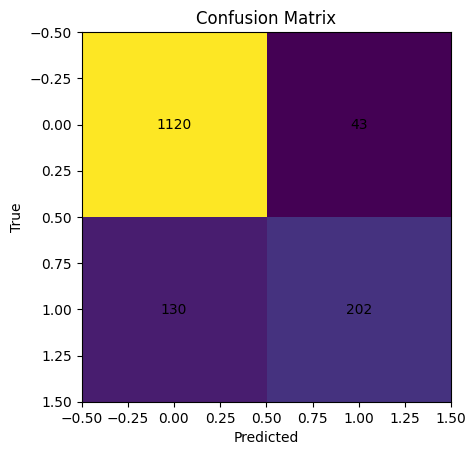

In [ ]:
# Importacion de librerias
import xml.etree.ElementTree as ET  # Analizar archivos XML (anotaciones)
from pathlib import Path
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Definición de directorios base
BASE_DIR   = Path("/content/pedestrian_dataset/Pedestrian Dataset/Train")
IMAGES_DIR = BASE_DIR / "JPEGImages"  # Carpeta con Imágenes
ANN_DIR    = BASE_DIR / "Annotations" # Carpeta con anotaciones en formato XML

# Parametros para HOG
WIN_SIZE = (64, 128)
HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    transform_sqrt=True,
    block_norm="L2-Hys",
    feature_vector=True
)

# Funciones Auxiliaries
def parse_boxes(xml_path):
    """
    Extrae las coordenadas de las cajas delimitadoras de personas desde un archivo XML de anotaciones.

    Parámetros:
        xml_path (str or Path): Ruta al archivo XML.

    Retorna:
        List[List[int]]: Lista de cajas delimitadoras [xmin, ymin, xmax, ymax] para cada persona encontrada.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []
    for obj in root.findall("object"):
        if obj.find("name").text.lower() != "person":
            continue # Ignorar objetos que no son personas
        bb = obj.find("bndbox")
        coords = [int(bb.find(tag).text) for tag in ("xmin","ymin","xmax","ymax")]
        boxes.append(coords)
    return boxes

def extract_hog(patch):
    """
    Convierte un recorte de imagen a escala de grises y extrae sus características HOG.

    Parámetros:
        patch (np.ndarray): Imagen recortada en formato BGR (color).

    Retorna:
        np.ndarray: Vector de características HOG.
    """
    gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    return hog(gray, **HOG_PARAMS)

# Recolección de muestras positivas - en este caso personas
pos_feats = []
for xml_file in ANN_DIR.glob("*.xml"):
    img = cv2.imread(str(IMAGES_DIR / f"{xml_file.stem}.jpg"))
    for box in parse_boxes(xml_file):
        x1, y1, x2, y2 = box
        patch = cv2.resize(img[y1:y2, x1:x2], WIN_SIZE) # Recortar y dimensiona el rostro detectado
        pos_feats.append(extract_hog(patch)) # Extrae características HOG

# Recolección de muestras negativas - en este caso NO-personas
neg_feats = []
np.random.seed(42)
for xml_file in ANN_DIR.glob("*.xml"):
    img = cv2.imread(str(IMAGES_DIR / f"{xml_file.stem}.jpg"))
    boxes = parse_boxes(xml_file)
    h, w = img.shape[:2]
    for _ in range(5): # Extraer 5 regiones aleatorias por imagen
        x = np.random.randint(0, w - WIN_SIZE[0])
        y = np.random.randint(0, h - WIN_SIZE[1])
        cand = [x, y, x+WIN_SIZE[0], y+WIN_SIZE[1]]


        def iou(a, b):
        """
        Calcula la intersección sobre unión (IoU) entre dos cajas delimitadoras para asegurarse de que no se superpongan.

        Parámetros:
            a (List[int]): Caja delimitadora A en el formato [x1, y1, x2, y2].
            b (List[int]): Caja delimitadora B en el formato [x1, y1, x2, y2].

        Retorna:
            float: Valor de IoU entre A y B.
        """
            xa1, ya1, xa2, ya2 = a; xb1, yb1, xb2, yb2 = b
            xi1, yi1 = max(xa1, xb1), max(ya1, yb1)
            xi2, yi2 = min(xa2, xb2), min(ya2, yb2)
            inter = max(0, xi2-xi1)*max(0, yi2-yi1)
            union = (xa2-xa1)*(ya2-ya1)+(xb2-xb1)*(yb2-yb1)-inter
            return inter/union if union>0 else 0

        # Solo acepta la región si no se superpone significativamente con ninguna caja positiva
        if all(iou(cand, b) < 0.1 for b in boxes):
            patch = cv2.resize(img[y:y+WIN_SIZE[1], x:x+WIN_SIZE[0]], WIN_SIZE)
            neg_feats.append(extract_hog(patch))

# Preparación del dataset
X = np.vstack((pos_feats, neg_feats)).astype(np.float64)
y = np.hstack((np.ones(len(pos_feats)), np.zeros(len(neg_feats))))

# Normalización de los datos
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Entrenamiento del Modelo SVM

#svc = LinearSVC(max_iter=10000, C=0.01)
#svc.fit(X_train, y_train)
svc = SVC()
svc.fit(X_train, y_train)

# Evaluación del model
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

# Generar matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.show()


**Análisis de los resultados:**

**Clase 0 (No Persona):** Observamos que el 90% de las veces el modelo predijo “no persona” correctamente, así mismo detecto correctamente el 96% de las regiones que realmente no contenían personas.

**Clase 1 (Persona):** Por otro lado, vemos que el 82% de las predicciones como persona fueron correctas. Sin embargo, el modelo solo detectó el 61% de las personas reales, lo cual indica una alta tasa de falsos negativos -> personas no detectadas.


In [ ]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.778 total time=  24.8s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.778 total time=  24.8s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.779 total time=  24.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.778 total time=  24.9s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.778 total time=  24.8s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.778 total time=  25.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.778 total time=  25.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.779 total time=  25.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.778 total time=  25.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.778 total time=  24.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.778 total time=  24.7s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=4)

In [ ]:
grid.best_params_

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

In [ ]:
grid.best_estimator_

SVC(C=100, gamma=0.0001)

In [ ]:
grid_predictions = grid.predict(X_test)

<Axes: >

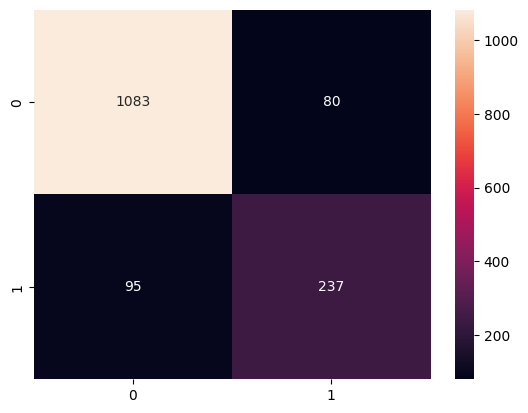

In [ ]:
cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt = "d")

In [ ]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93      1163
         1.0       0.75      0.71      0.73       332

    accuracy                           0.88      1495
   macro avg       0.83      0.82      0.83      1495
weighted avg       0.88      0.88      0.88      1495



**Análisis de los nuevos resultados:**

**Clase 0 (No Persona):** Observamos una alta precisión (92%), lo que indica que el modelo rara vez predice erróneamente “persona” cuando no lo es. Así mismo mantiene una buena capacidad de identificar correctamente la mayoría de las regiones negativas (93%).

**Clase 1 (Persona):** vemos que se tuvo un ligero descenso (75%) vs el resultado anterior (82%), sin embargo, vemos una mejora importante en la métrica de Recall (71% vs 61% del resultado anterior), lo que indica que ahora el modelo está detectando más personas correctamente.

En conclusión, el modelo mejoro significativamente su capacidad de detección de personas, a pesar de que hubo un ligero descenso en la precisión para personas, si el objetivo es reducir los falsos negativos (no dejar pasar personas sin detectar), entonces seria favorable la mejora.
